In [1]:
# Built-in
import os
import itertools
import multiprocessing

# Analysis packages
import scanpy as sc
import anndata as ad
import numpy as np
import pandas as pd
import memento
from statsmodels.stats.multitest import multipletests
from scipy import stats

# Plotting packages
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

# Set number of cores to use
sc.settings.n_jobs = 8

sc.logging.print_header()

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.5.3 scikit-learn==0.24.2 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [2]:
pd.set_option('display.max_columns', 40)

In [3]:
REPLICATE = "replicate1"

In [4]:
adata = sc.read( f"treatment-combinations-subsampled-{REPLICATE}.h5ad")
adata

AnnData object with n_obs × n_vars = 77945 × 24181
    obs: 'time', 'time_str', 'drug', 'sex', 'approx_reads_per_cell', 'date', 'label', 'batch', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_genes', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'hvg', 'label_colors', 'label_colors_dict', 'label_order', 'log1p', 'rank_genes_groups', 'scrublet', 'stage_colors_dict', 'stage_order'
    obsm: 'X_pca', 'X_umap'
    layers: 'ds_norm_cts', 'raw-cts_pre-ds'

In [7]:
adata.obs.head(2)

time time_str drug sex approx_reads_per_cell  \
AGGAATAAGCCTAACT-1-1h_Ket_M_445     1        1  Ket   M                   25K   
CCTTGTGCATGACTAC-1-1h_Ket_M_445     1        1  Ket   M                   25K   

                                date         label batch sample  \
AGGAATAAGCCTAACT-1-1h_Ket_M_445  NaN  1h_Ket_M_445  6887     35   
CCTTGTGCATGACTAC-1-1h_Ket_M_445  NaN  1h_Ket_M_445  6887     35   

                                 n_genes_by_counts  log1p_n_genes_by_counts  \
AGGAATAAGCCTAACT-1-1h_Ket_M_445               4878                 8.492696   
CCTTGTGCATGACTAC-1-1h_Ket_M_445               5983                 8.696845   

                                 total_counts  log1p_total_counts  n_counts  \
AGGAATAAGCCTAACT-1-1h_Ket_M_445  22054.966797           10.001339   24204.0   
CCTTGTGCATGACTAC-1-1h_Ket_M_445  24742.087891           10.116302   42344.0   

                                 n_genes  doublet_score  log10_gene_counts  \
AGGAATAAGCCTAACT-1-1h_Ket_M_445     4918       0.088000           3.691789   
CCTTGTGCATGACTAC-1-1h_Ket_M_445     6033       0.129771           3.780533   

                                 log10_UMI_counts  percent_mito  percent_ribo  \
AGGAATAAGCCTAACT-1-1h_Ket_M_445          4.402416      0.001465      0.001623   
CCTTGTGCATGACTAC-1-1h_Ket_M_445          4.647510      0.000473      0.001238   

                                leiden  
AGGAATAAGCCTAACT-1-1h_Ket_M_445      0  
CCTTGTGCATGACTAC-1-1h_Ket_M_445      0

# Load Sequencing Saturation

In [8]:
samples = pd.read_csv("/nfs/turbo/umms-kykwan/projects/alex_kwan/PsiloKet snRNA Seq (2022-11-19).csv").astype({"Mouse ID": str})
# Select samples with NO reason for exclusion
samples = samples[samples["Reason for Exclusion"].isna()]

# Swapped sex
samples.loc[np.isin(samples['Mouse ID'], ["470"]), 'Sex'] = 'M'

samples["label"] = samples["Timepoint"] + "_" + samples["Drug"] + "_" + samples["Sex"] + "_" + samples["Mouse ID"]
# Only keep necessary columns
samples = samples[["label", "Seq ID"]]
samples.head(2)

label     Seq ID
0  0h_none_F_346  6155-CL-1
1  0h_none_F_347  6128-CL-1

In [9]:
# Read sequencing saturation
metrics = pd.read_csv("/nfs/turbo/umms-kykwan/projects/alex_kwan/10x_metrics.csv").set_index("Sample")
# Convert 40.5% to 0.405
metrics["Sequencing Saturation"] = metrics["Sequencing Saturation"].str.rstrip('%').astype('float') / 100.0
# Using only the columns we care about
metrics = metrics[["Sequencing Saturation"]]
metrics.head(2)

Sequencing Saturation
Sample                          
6155-CL-1                  0.405
6128-CL-1                  0.634

In [10]:
# Add Seq ID to adata.obs
adata.obs = (adata.obs.reset_index() # Reset index into a column so that it is not lost
             .merge(samples, how='left', on="label") # Add Seq ID
             .merge(metrics, how='left', left_on="Seq ID", right_index=True) # Add Sequencing Saturation
             .set_index("index")) # Re-add index

# 0.25 as specified by memento docs for 10x v3
adata.obs['capture_rate'] = 0.25 * adata.obs['Sequencing Saturation']
adata.obs.head()

time time_str drug sex approx_reads_per_cell  \
index                                                                           
AGGAATAAGCCTAACT-1-1h_Ket_M_445     1        1  Ket   M                   25K   
CCTTGTGCATGACTAC-1-1h_Ket_M_445     1        1  Ket   M                   25K   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445     1        1  Ket   M                   25K   
TATTGCTCACTCATAG-1-1h_Ket_F_408     1        1  Ket   F                   25K   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354     1        1  Ket   F                   25K   

                                    date         label batch sample  \
index                                                                 
AGGAATAAGCCTAACT-1-1h_Ket_M_445      NaN  1h_Ket_M_445  6887     35   
CCTTGTGCATGACTAC-1-1h_Ket_M_445      NaN  1h_Ket_M_445  6887     35   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445      NaN  1h_Ket_M_445  6887     35   
TATTGCTCACTCATAG-1-1h_Ket_F_408  4/27/22  1h_Ket_F_408  6163     26   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354   4/6/22  1h_Ket_F_354  6141     25   

                                 n_genes_by_counts  log1p_n_genes_by_counts  \
index                                                                         
AGGAATAAGCCTAACT-1-1h_Ket_M_445               4878                 8.492696   
CCTTGTGCATGACTAC-1-1h_Ket_M_445               5983                 8.696845   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445               2627                 7.873978   
TATTGCTCACTCATAG-1-1h_Ket_F_408               4999                 8.517193   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354               2447                 7.803027   

                                 total_counts  log1p_total_counts  n_counts  \
index                                                                         
AGGAATAAGCCTAACT-1-1h_Ket_M_445  22054.966797           10.001339   24204.0   
CCTTGTGCATGACTAC-1-1h_Ket_M_445  24742.087891           10.116302   42344.0   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445  14274.798828            9.566321    7227.0   
TATTGCTCACTCATAG-1-1h_Ket_F_408  22331.166016           10.013783   26615.0   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354  13668.094727            9.522893    5849.0   

                                 n_genes  doublet_score  log10_gene_counts  \
index                                                                        
AGGAATAAGCCTAACT-1-1h_Ket_M_445     4918       0.088000           3.691789   
CCTTGTGCATGACTAC-1-1h_Ket_M_445     6033       0.129771           3.780533   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445     2658       0.045226           3.424555   
TATTGCTCACTCATAG-1-1h_Ket_F_408     5036       0.038876           3.702086   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354     2468       0.040225           3.392345   

                                 log10_UMI_counts  percent_mito  percent_ribo  \
index                                                                           
AGGAATAAGCCTAACT-1-1h_Ket_M_445          4.402416      0.001465      0.001623   
CCTTGTGCATGACTAC-1-1h_Ket_M_445          4.647510      0.000473      0.001238   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445          3.876910      0.001726      0.003452   
TATTGCTCACTCATAG-1-1h_Ket_F_408          4.452032      0.000141      0.001625   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354          3.781181      0.000000      0.003641   

                                leiden     Seq ID  Sequencing Saturation  \
index                                                                      
AGGAATAAGCCTAACT-1-1h_Ket_M_445      0  6887-CL-4                  0.425   
CCTTGTGCATGACTAC-1-1h_Ket_M_445      0  6887-CL-4                  0.425   
TGAGCGCGTTTGACAC-1-1h_Ket_M_445      0  6887-CL-4                  0.425   
TATTGCTCACTCATAG-1-1h_Ket_F_408      0  6163-CL-1                  0.529   
CAAGAGGGTTCGTTCC-1-1h_Ket_F_354      0  6141-CL-1                  0.349   

                                 capture_rate  
index                                          
AGGAATAAGCCTAACT-1-1h_Ket_M_445       0.10625  
CCTTGTGCATGACTAC-1-1h_Ket_M_445       0.10625  
TGAGCGCGTTTGACAC-1-

# Simple Memento test

In [11]:
cluster = "0"
drug = "Ket"
time = "24"

subset = adata[(adata.obs["leiden"] == cluster) &
               (np.isin(adata.obs["drug"], [drug, "none"])) &
               (np.isin(adata.obs["time_str"], [time, "0"]))]

subset.obs["stim"] = (subset.obs["drug"] == drug).astype(int)


/tmp/ipykernel_819968/3097586924.py:9: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  subset.obs["stim"] = (subset.obs["drug"] == drug).astype(int)


In [12]:
%%time
result_1d = memento.binary_test_1d(
    adata=subset,
    # Multiple by 0.25 because this is 10x v3
    capture_rate=0.25 * subset.obs["Sequencing Saturation"].mean(),
    treatment_col="stim",
    num_cpus=36,
    num_boot=5000
)

[Parallel(n_jobs=36)]: Using backend LokyBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 128 tasks      | elapsed:   31.8s
[Parallel(n_jobs=36)]: Done 378 tasks      | elapsed:   37.5s
[Parallel(n_jobs=36)]: Done 728 tasks      | elapsed:   45.3s
[Parallel(n_jobs=36)]: Done 1178 tasks      | elapsed:   54.5s
[Parallel(n_jobs=36)]: Done 1728 tasks      | elapsed:  1.1min
[Parallel(n_jobs=36)]: Done 2378 tasks      | elapsed:  1.3min
[Parallel(n_jobs=36)]: Done 3128 tasks      | elapsed:  1.5min
[Parallel(n_jobs=36)]: Done 3978 tasks      | elapsed:  1.8min
[Parallel(n_jobs=36)]: Done 4928 tasks      | elapsed:  2.1min
[Parallel(n_jobs=36)]: Done 5978 tasks      | elapsed:  2.4min
[Parallel(n_jobs=36)]: Done 7128 tasks      | elapsed:  2.7min
[Parallel(n_jobs=36)]: Done 8378 tasks      | elapsed:  3.2min
[Parallel(n_jobs=36)]: Done 9728 tasks      | elapsed:  3.6min
[Parallel(n_jobs=36)]: Done 11178 tasks      | elapsed:  4.1min
[Parallel(n_jobs=36)]: Done 12372 out of 12

CPU times: user 21.1 s, sys: 6.44 s, total: 27.6 s
Wall time: 4min 34s


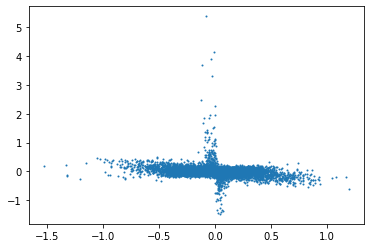

In [13]:
plt.scatter(result_1d.de_coef, result_1d.dv_coef, s=1)

In [14]:
result_1d.query('de_coef > 0').sort_values('de_pval').head(20)

gene    tx   de_coef     de_se   de_pval   dv_coef     dv_se  \
1380           Lzts3  stim  0.308262  0.063944  0.000206 -0.013554  0.050273   
1411   4930545L23Rik  stim  0.641965  0.116388  0.000228  0.258520  0.060109   
2618         Gm42303  stim  0.394966  0.081228  0.000243  0.138122  0.036345   
11422       Arhgef37  stim  0.738929  0.137428  0.000325  0.305909  0.052735   
9057   4930415C11Rik  stim  0.469524  0.124446  0.000392  0.129783  0.048877   
1866         Gm43376  stim  0.512053  0.110349  0.000503  0.179780  0.055118   
5437             Bc1  stim  0.480999  0.106611  0.000583  0.340642  0.055838   
6046   C230057M02Rik  stim  0.292062  0.071063  0.000655  0.051570  0.043969   
551          Gm37679  stim  0.399714  0.099088  0.001021  0.167611  0.057459   
2408           Calb1  stim  0.189948  0.052834  0.001041 -0.129097  0.066080   
9953   1700109K24Rik  stim  0.571855  0.148877  0.001095  0.092809  0.055356   
2508          Unc13b  stim  0.142520  0.039295  0.001225 -0.290103  0.149403   
8109            Hap1  stim  0.345524  0.091550  0.001304  0.142637  0.049315   
10880         Hnrnpm  stim  0.182475  0.050597  0.001443 -0.210112  0.087071   
555          Gm36975  stim  0.190399  0.053972  0.001642 -0.077250  0.058104   
7361          Rassf3  stim  0.428803  0.116211  0.001694  0.073785  0.074696   
3678        AI480526  stim  0.312575  0.091556  0.001709  0.097386  0.047787   
8580   4930447C04Rik  stim  0.203139  0.057516  0.001730 -0.046773  0.053654   
959             Cdk9  stim  0.307878  0.085972  0.001803  0.105632  0.050135   
5865           Nup93  stim  0.117426  0.035022  0.001813 -0.516930  0.230972   

        dv_pval  
1380   0.788242  
1411   0.000395  
2618   0.002886  
11422  0.000202  
9057   0.008198  
1866   0.002326  
5437   0.000111  
6046   0.238152  
551    0.004399  
2408   0.049990  
9953   0.093781  
2508   0.052190  
8109   0.004799  
10880  0.019196  
555    0.184963  
7361   0.317536  
3678   0.041592  
8580   0.376725  
959    0.034393  
5865   0.030194

# Memento (time covariate) Analysis

In [15]:
results = {}

In [18]:
%%time
# single process
drugs = ["Ket", "Psilo"]
times = adata.uns["stage_order"][1:] # Skip 0 hours (ctrl)
clusters = np.sort(adata.obs["leiden"].unique())

categorical_covariates = ["sex"]
numerical_covariates = ["time"]

for drug, cluster in itertools.product(drugs, clusters):
#     print('remove the break statment if you want this to actually run')
#     break    
    
    group = f"{drug}_{cluster}"
    print(f"{group} vs ctrl")
    
    if group in results:
        print(f"Skipping {group}, already in results")
        continue
    
    data = adata[(adata.obs["leiden"] == cluster) &
            (np.isin(adata.obs["drug"], [drug, "none"]))].copy()
    data.obs["stim"] = data.obs["drug"].replace({drug: 1, "none": 0})
    
    if data.shape[0] < 100:
        results[group] = pd.DataFrame()
        print(f"Skipping {group}, < 100 cells")
        continue

    # Make the columns into numbers
    for col in categorical_covariates:
        data.obs[col] = pd.factorize(data.obs[col])[0].astype(float)  
    
    cols = ["stim"] + categorical_covariates + numerical_covariates
    print("Data Shape:", data.shape)
    memento.setup_memento(data, q_column='capture_rate')
    memento.create_groups(data, label_columns=cols)
    
    sizes = data.obs.groupby(cols).size()
    if ((sizes > 0) & (sizes < 10)).any():
        results[group] = pd.DataFrame()
        print(f"Skipping {group}, < 10 cells in some groups")
        continue
    
    memento.compute_1d_moments(data)
    print("Data Shape after compute_1d_moments:", data.shape)
    
    sample_meta = memento.get_groups(data)
    treatment_df = sample_meta[['stim']]
    covariates_df = sample_meta.drop('stim', axis=1)
    
    memento.ht_1d_moments(data, 
                          treatment=treatment_df,
                          covariate=covariates_df,
                          num_boot=5000, 
                          verbose=1,
                          num_cpus=64)
    
    result_1d = memento.get_1d_ht_result(data)
    
    # Correct p-vals
    _, result_1d["de_pval_adj"], _, _ = multipletests(
    result_1d["de_pval"], alpha=0.05, method='fdr_bh'
    )

    _, result_1d["dv_pval_adj"], _, _ = multipletests(
        result_1d["dv_pval"], alpha=0.05, method='fdr_bh'
    )
    
    results[group] = result_1d.sort_values(by=["de_pval_adj", "dv_pval_adj"])


Ket_0 vs ctrl
Skipping Ket_0, already in results
Ket_1 vs ctrl
Skipping Ket_1, already in results
Ket_10 vs ctrl
Skipping Ket_10, already in results
Ket_12 vs ctrl
Skipping Ket_12, already in results
Ket_2 vs ctrl
Skipping Ket_2, already in results
Ket_3 vs ctrl
Skipping Ket_3, already in results
Ket_4 vs ctrl
Skipping Ket_4, already in results
Ket_5 vs ctrl
Skipping Ket_5, already in results
Ket_6 vs ctrl
Skipping Ket_6, already in results
Ket_7 vs ctrl
Skipping Ket_7, already in results
Ket_8 vs ctrl
Skipping Ket_8, already in results
Ket_9 vs ctrl
Skipping Ket_9, already in results
Psilo_0 vs ctrl
Skipping Psilo_0, already in results
Psilo_1 vs ctrl
Skipping Psilo_1, already in results
Psilo_10 vs ctrl
Skipping Psilo_10, already in results
Psilo_12 vs ctrl
Skipping Psilo_12, already in results
Psilo_2 vs ctrl
Skipping Psilo_2, already in results
Psilo_3 vs ctrl
Skipping Psilo_3, already in results
Psilo_4 vs ctrl
Skipping Psilo_4, already in results
Psilo_5 vs ctrl
Skipping Psilo_5,

In [19]:
# Write results to Excel
for drug in drugs:
    with pd.ExcelWriter(f"memento_output/{REPLICATE}/memento_DE_{drug}_time_covariate.xlsx", engine="openpyxl") as writer:
        for cluster in clusters:
            results[f"{drug}_{cluster}"].to_excel(writer, sheet_name = f"Cluster {cluster}")

# Memento (no covariate) Analysis

In [20]:
results = {}

In [21]:
%%time

drugs = ["Ket", "Psilo"]
times = adata.uns["stage_order"][1:] # Skip 0 hours (ctrl)
clusters = np.sort(adata.obs["leiden"].unique())

for time, drug, cluster in itertools.product(times, drugs, clusters):
    group = f"{time}h_{drug}_{cluster}"
    print(f"{group} vs ctrl")
    
    if group in results:
        print(f"Skipping {group}, already in results")
        continue
    
    data = adata[(adata.obs["leiden"] == cluster) &
            (np.isin(adata.obs["drug"], [drug, "none"])) &
            (np.isin(adata.obs["time_str"], [time, "0"]))].copy()
    data.obs["stim"] = data.obs["drug"].replace({drug: 1, "none": 0})
    
    if data.shape[0] < 100:
        results[group] = pd.DataFrame()
        print(f"Skipping {group}, < 100 cells")
        continue

    cols = ["stim"]
    print("Data Shape:", data.shape)
    memento.setup_memento(data, q_column='capture_rate')
    memento.create_groups(data, label_columns=cols)
    
    if (data.obs.groupby(cols).size() < 10).any():
        results[group] = pd.DataFrame()
        print(f"Skipping {group}, < 10 cells in some groups")
        continue
    
    memento.compute_1d_moments(data)
    print("Data Shape after compute_1d_moments:", data.shape)
    
    sample_meta = memento.get_groups(data)
    treatment_df = sample_meta[['stim']]
    
    memento.ht_1d_moments(data, 
                          treatment=treatment_df,
                          num_boot=5000, 
                          verbose=1,
                          num_cpus=64)
    
    result_1d = memento.get_1d_ht_result(data)
    
    # Correct p-vals
    _, result_1d["de_pval_adj"], _, _ = multipletests(
        result_1d["de_pval"], alpha=0.05, method='fdr_bh'
    )

    _, result_1d["dv_pval_adj"], _, _ = multipletests(
        result_1d["dv_pval"], alpha=0.05, method='fdr_bh'
    )
    
    results[group] = result_1d.sort_values(by=["de_pval_adj", "dv_pval_adj"])


1h_Ket_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12207)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   27.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   39.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   52.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  4.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  5.1min
[Parallel(n_jobs=64)]: Done 12207 out of 12

1h_Ket_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11647)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   15.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   26.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   39.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   52.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.1min
[Parallel(n_jobs=64)]: Done 11647 out of 11

1h_Ket_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12046)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   38.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   56.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12046 out of 12

1h_Ket_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11549)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   22.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   31.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   43.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   56.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11549 out of 11

1h_Ket_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12087)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 441 tasks      | elapsed:    9.6s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   16.5s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   25.8s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   36.2s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   48.6s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12087 out of 12

1h_Ket_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12397)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 438 tasks      | elapsed:   10.3s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   18.6s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   29.1s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   41.6s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   56.0s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12397 out of 12

1h_Ket_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8809)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 487 tasks      | elapsed:    6.5s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   11.2s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   16.9s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   23.7s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   32.1s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   41.4s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:   51.7s
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8809 out of 8809 | elapsed:  1.8min finished


1h_Ket_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12227)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   22.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   35.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   47.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 12227 out of 12

1h_Ket_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10354)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 488 tasks      | elapsed:    8.0s
[Parallel(n_jobs=64)]: Done 862 tasks      | elapsed:   13.5s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   20.1s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   27.5s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   36.8s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   46.6s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:   57.8s
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 10354 out of 10354 | elapsed:  2.4min finished


1h_Ket_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12385)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   43.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  4.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.9min
[Parallel(n_jobs=64)]: Done 12385 out of 12

1h_Ket_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11983)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 473 tasks      | elapsed:    8.8s
[Parallel(n_jobs=64)]: Done 861 tasks      | elapsed:   15.1s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   25.0s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   37.1s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   50.3s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11983 out of 11

1h_Ket_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10448)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 516 tasks      | elapsed:    4.4s
[Parallel(n_jobs=64)]: Done 928 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 1378 tasks      | elapsed:   10.3s
[Parallel(n_jobs=64)]: Done 1928 tasks      | elapsed:   14.2s
[Parallel(n_jobs=64)]: Done 2578 tasks      | elapsed:   22.1s
[Parallel(n_jobs=64)]: Done 3328 tasks      | elapsed:   32.0s
[Parallel(n_jobs=64)]: Done 4178 tasks      | elapsed:   42.5s
[Parallel(n_jobs=64)]: Done 5128 tasks      | elapsed:   53.7s
[Parallel(n_jobs=64)]: Done 6178 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 7328 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8578 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9928 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 10448 out of 10448 | elapsed:  2.4min finished


1h_Psilo_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11819)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   10.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   20.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   32.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   47.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.5min
[Parallel(n_jobs=64)]: Done 11819 out of 11

1h_Psilo_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11205)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 471 tasks      | elapsed:    9.8s
[Parallel(n_jobs=64)]: Done 860 tasks      | elapsed:   18.6s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   29.6s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   42.2s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   57.4s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11205 out of 11205 | elapsed:  4.2min finished


1h_Psilo_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11568)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 434 tasks      | elapsed:   12.1s
[Parallel(n_jobs=64)]: Done 799 tasks      | elapsed:   20.8s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   33.2s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   46.5s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.3min
[Parallel(n_jobs=64)]: Done 11568 out of 11

1h_Psilo_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11098)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 474 tasks      | elapsed:    9.0s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   20.9s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   29.1s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   38.2s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   50.9s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11098 out of 11098 | elapsed:  3.4min finished


1h_Psilo_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11458)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 430 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   21.4s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   33.4s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   46.7s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.5min
[Parallel(n_jobs=64)]: Done 11458 out of 11

1h_Psilo_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12085)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 434 tasks      | elapsed:   11.3s
[Parallel(n_jobs=64)]: Done 799 tasks      | elapsed:   19.6s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   31.0s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   43.6s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   59.6s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.4min
[Parallel(n_jobs=64)]: Done 12085 out of 12

1h_Psilo_4 vs ctrl
Data Shape: (595, 24181)
Data Shape after compute_1d_moments: (595, 9510)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid va

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, Non

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid va

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
[Parallel(n_jobs=64)]: Done 7392 tasks      | elapsed:   45.4s
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: inv

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid va

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, Non

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/samp

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddo

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  v

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sa

/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/etofarre/.local/lib/python3.9/site-packages/memento/hypothesis_test.py:238: RuntimeWarning: invalid value encountered in divide
  return A_mA.T.dot(np.diag(sample_weight)).dot(B_mB)/sample_weight.sum() / ssA[:, None]
/home/etofarre/.local/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dt

1h_Psilo_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11889)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.4s
[Parallel(n_jobs=64)]: Done 428 tasks      | elapsed:   10.9s
[Parallel(n_jobs=64)]: Done 799 tasks      | elapsed:   19.1s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   30.3s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   43.2s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   57.4s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.3min
[Parallel(n_jobs=64)]: Done 11889 out of 11

1h_Psilo_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 9659)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 433 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 798 tasks      | elapsed:   14.3s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   21.3s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   30.0s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   39.9s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:   50.3s
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9659 out of 9659 | elapsed:  2.5min finished


1h_Psilo_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12391)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 435 tasks      | elapsed:   12.1s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   20.5s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   33.1s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   47.1s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.3min
[Parallel(n_jobs=64)]: Done 12391 out of 12

1h_Psilo_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11519)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   18.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   28.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   42.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   56.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 11519 out of 11

1h_Psilo_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 9770)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 487 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 861 tasks      | elapsed:   13.1s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   20.3s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   28.1s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   36.5s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   46.2s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:   57.4s
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9770 out of 9770 | elapsed:  1.9min finished


2h_Ket_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12234)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 478 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 861 tasks      | elapsed:   17.2s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   24.6s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   34.3s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   45.6s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   58.2s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 12234 out of 12

2h_Ket_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11681)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 486 tasks      | elapsed:    9.8s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   16.2s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   25.6s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   35.9s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   48.4s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11681 out of 11

2h_Ket_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12008)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 428 tasks      | elapsed:    8.5s
[Parallel(n_jobs=64)]: Done 798 tasks      | elapsed:   14.6s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   22.4s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   31.2s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   43.7s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:   56.6s
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 12008 out of 12

2h_Ket_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11447)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   14.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   20.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   28.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   37.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   48.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 11447 out of 11

2h_Ket_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12091)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 434 tasks      | elapsed:    9.5s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   14.4s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   30.5s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   41.5s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   56.2s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12091 out of 12

2h_Ket_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12438)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 493 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   23.8s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   39.1s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  4.1min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  4.6min
[Parallel(n_jobs=64)]: Done 12438 out of 12

2h_Ket_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8981)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    9.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   22.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   29.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   41.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   51.8s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 8981 out of 8981 | elapsed:  1.9min finished


2h_Ket_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12307)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 437 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   18.8s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   28.5s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   40.7s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   54.3s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.1min
[Parallel(n_jobs=64)]: Done 12307 out of 12

2h_Ket_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10352)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   17.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   26.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   36.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   47.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   59.7s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 10352 out of 10352 | elapsed:  2.8min finished


2h_Ket_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12664)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 435 tasks      | elapsed:   11.8s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   20.1s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   26.1s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   35.8s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   50.8s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12664 out of 12

2h_Ket_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11939)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   24.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   36.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   49.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11939 out of 11

2h_Ket_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10303)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   16.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   24.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   35.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   46.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   58.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 10303 out of 10303 | elapsed:  2.5min finished


2h_Psilo_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12350)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   26.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   38.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   52.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.9min
[Parallel(n_jobs=64)]: Done 12350 out of 12

2h_Psilo_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11734)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 436 tasks      | elapsed:   10.0s
[Parallel(n_jobs=64)]: Done 798 tasks      | elapsed:   16.0s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   25.1s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   36.3s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   48.9s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11734 out of 11

2h_Psilo_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12141)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   23.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   33.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   45.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   58.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 12141 out of 12

2h_Psilo_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11618)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   12.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   30.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   40.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   54.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11618 out of 11

2h_Psilo_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12169)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.5s
[Parallel(n_jobs=64)]: Done 435 tasks      | elapsed:   13.0s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   21.2s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   31.5s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   44.2s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   58.3s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 12169 out of 12

2h_Psilo_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12457)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   31.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   44.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   59.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 12457 out of 12

2h_Psilo_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 9053)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   14.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   20.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   27.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   35.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   43.8s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   49.4s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   55.5s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 9053 out of 9053 | elapsed:  1.5min finished


2h_Psilo_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12364)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   23.3s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   34.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   46.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12364 out of 12

2h_Psilo_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10433)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    9.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   21.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   29.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   38.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   49.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 10433 out of 10433 | elapsed:  2.2min finished


2h_Psilo_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12747)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   20.0s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   29.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   41.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   54.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 12747 out of 12

2h_Psilo_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12056)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   23.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   33.4s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   46.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   59.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 12056 out of 12

2h_Psilo_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10548)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 439 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   11.7s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   21.4s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   27.3s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   36.2s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:   45.9s
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:   56.8s
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 10548 out of 10548 | elapsed:  2.4min finished


4h_Ket_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12279)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   21.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   31.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   50.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 12279 out of 12

4h_Ket_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11734)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 443 tasks      | elapsed:    8.9s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   15.2s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   24.0s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   34.6s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   46.7s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 11734 out of 11

4h_Ket_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12076)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 440 tasks      | elapsed:    9.1s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   15.4s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   24.0s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   33.3s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   45.1s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:   55.1s
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 12076 out of 12

4h_Ket_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11503)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   11.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   18.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   26.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   36.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   47.7s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 11503 out of 11

4h_Ket_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12225)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   27.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   35.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   50.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 12225 out of 12

4h_Ket_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12561)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   15.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   24.4s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   35.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   48.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 12561 out of 12

4h_Ket_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8910)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   13.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   19.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   26.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   34.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   43.1s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   48.5s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   54.3s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 8910 out of 8910 | elapsed:  1.5min finished


4h_Ket_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12378)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 441 tasks      | elapsed:    9.9s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   17.5s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   27.2s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   37.7s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   50.7s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 12378 out of 12

4h_Ket_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10272)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    9.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   22.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   30.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   39.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   50.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 10272 out of 10272 | elapsed:  2.2min finished


4h_Ket_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12888)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.0s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   25.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   35.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   49.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   59.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12672 tasks    

4h_Ket_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11972)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   24.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   34.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   48.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 11972 out of 11

4h_Ket_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10304)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 438 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   11.1s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   17.3s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   24.2s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   32.7s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:   41.7s
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:   51.6s
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 10304 out of 10304 | elapsed:  2.2min finished


4h_Psilo_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12415)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 492 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   13.9s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   23.7s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   34.5s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   47.4s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12415 out of 12

4h_Psilo_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11762)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   12.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.4s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   31.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   42.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   56.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11762 out of 11

4h_Psilo_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12138)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   12.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.3s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   30.4s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   42.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   54.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 12138 out of 12

4h_Psilo_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11557)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   19.3s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   27.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   37.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   48.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 11557 out of 11

4h_Psilo_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12288)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   19.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   24.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   33.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   47.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 12288 out of 12

4h_Psilo_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12619)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   24.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   35.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   48.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 12619 out of 12

4h_Psilo_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8967)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   14.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   20.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   27.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   36.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   42.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   48.0s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:   54.1s
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 8967 out of 8967 | elapsed:  1.5min finished


4h_Psilo_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12430)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   22.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   33.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   46.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12430 out of 12

4h_Psilo_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10435)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    9.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   22.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   30.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   39.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   49.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 10435 out of 10435 | elapsed:  2.2min finished


4h_Psilo_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12756)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   11.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   19.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   29.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   41.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   48.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 12756 out of 12

4h_Psilo_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12057)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   22.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   32.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   44.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   58.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 12057 out of 12

4h_Psilo_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10352)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   10.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   20.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   28.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   37.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   46.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   57.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 10352 out of 10352 | elapsed:  2.3min finished


24h_Ket_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12373)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 444 tasks      | elapsed:    9.3s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   16.4s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   25.5s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   35.5s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   47.9s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 12373 out of 12

24h_Ket_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11723)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.4s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   30.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   39.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   54.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11723 out of 11

24h_Ket_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12079)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.0s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   21.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   30.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   41.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   50.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 12079 out of 12

24h_Ket_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11511)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   11.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   19.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   26.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   36.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   48.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 11511 out of 11

24h_Ket_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12203)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   22.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   27.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   33.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   45.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 12203 out of 12

24h_Ket_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12639)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   23.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   34.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   46.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 12639 out of 12

24h_Ket_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8863)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   13.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   19.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   27.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   35.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   44.4s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   55.4s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 8863 out of 8863 | elapsed:  1.5min finished


24h_Ket_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12451)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   13.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   22.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   32.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   44.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   58.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 12451 out of 12

24h_Ket_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10329)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    5.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:    8.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   12.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   20.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   32.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   43.6s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   56.6s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 10329 out of 10329 | elapsed:  2.3min finished


24h_Ket_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12783)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   40.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   52.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12783 out of 12

24h_Ket_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11973)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 474 tasks      | elapsed:    8.0s
[Parallel(n_jobs=64)]: Done 858 tasks      | elapsed:   13.0s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   20.2s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   28.4s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   38.5s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   49.9s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11973 out of 11

24h_Ket_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10352)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 473 tasks      | elapsed:    6.3s
[Parallel(n_jobs=64)]: Done 858 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   14.6s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   18.1s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   22.4s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   27.0s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:   32.1s
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:   43.0s
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:   54.9s
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 10352 out of 10352 | elapsed:  1.7min finished


24h_Psilo_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12314)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 475 tasks      | elapsed:    8.7s
[Parallel(n_jobs=64)]: Done 862 tasks      | elapsed:   14.4s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   22.2s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   31.4s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   43.7s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   56.1s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 12314 out of 12

24h_Psilo_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11749)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 477 tasks      | elapsed:    7.6s
[Parallel(n_jobs=64)]: Done 862 tasks      | elapsed:   12.8s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   20.3s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   28.1s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   38.2s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   51.7s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11749 out of 11

24h_Psilo_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12122)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   11.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   16.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   26.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   39.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   52.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 12122 out of 12

24h_Psilo_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11533)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 516 tasks      | elapsed:    5.0s
[Parallel(n_jobs=64)]: Done 928 tasks      | elapsed:    9.5s
[Parallel(n_jobs=64)]: Done 1378 tasks      | elapsed:   18.0s
[Parallel(n_jobs=64)]: Done 1928 tasks      | elapsed:   27.4s
[Parallel(n_jobs=64)]: Done 2578 tasks      | elapsed:   38.5s
[Parallel(n_jobs=64)]: Done 3328 tasks      | elapsed:   50.0s
[Parallel(n_jobs=64)]: Done 4178 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5128 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 6178 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 7328 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8578 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9928 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 11378 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11533 out of 11

24h_Psilo_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12161)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   12.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   17.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   26.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   41.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12161 out of 12

24h_Psilo_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12524)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   28.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   42.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.3min
[Parallel(n_jobs=64)]: Done 12524 out of 12

24h_Psilo_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 9102)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.4s
[Parallel(n_jobs=64)]: Done 479 tasks      | elapsed:    7.5s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   18.0s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   25.4s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   34.1s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   43.3s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:   53.4s
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 9102 out of 9102 | elapsed:  2.0min finished


24h_Psilo_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12343)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 493 tasks      | elapsed:    8.5s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   24.4s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   33.5s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   45.2s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   59.6s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 12343 out of 12

24h_Psilo_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10530)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 475 tasks      | elapsed:    9.7s
[Parallel(n_jobs=64)]: Done 863 tasks      | elapsed:   15.7s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   22.0s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   29.6s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   39.3s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   49.7s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 10530 out of 10530 | elapsed:  2.6min finished


24h_Psilo_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12682)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 436 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   19.2s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   28.7s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   42.2s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   57.7s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12682 out of 12

24h_Psilo_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12032)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   15.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   24.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   35.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   49.5s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 12032 out of 12

24h_Psilo_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10419)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done 482 tasks      | elapsed:    8.5s
[Parallel(n_jobs=64)]: Done 863 tasks      | elapsed:   14.3s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   21.4s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   28.9s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   42.6s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   53.6s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 10419 out of 10419 | elapsed:  2.6min finished


72h_Ket_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12231)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 430 tasks      | elapsed:    9.2s
[Parallel(n_jobs=64)]: Done 798 tasks      | elapsed:   16.3s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   25.2s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   36.1s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   50.5s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.9min
[Parallel(n_jobs=64)]: Done 12231 out of 12

72h_Ket_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11622)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  73 tasks      | elapsed:    1.7s
[Parallel(n_jobs=64)]: Done 431 tasks      | elapsed:    9.5s
[Parallel(n_jobs=64)]: Done 799 tasks      | elapsed:   16.6s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   26.4s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   36.8s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   44.7s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11622 out of 11

72h_Ket_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12088)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   17.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   28.4s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   41.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   57.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 12088 out of 12

72h_Ket_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11604)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.5s
[Parallel(n_jobs=64)]: Done 480 tasks      | elapsed:    9.2s
[Parallel(n_jobs=64)]: Done 863 tasks      | elapsed:   15.9s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   20.6s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   29.8s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   41.6s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   58.0s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11604 out of 11

72h_Ket_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12119)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   23.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   35.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   48.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.3min
[Parallel(n_jobs=64)]: Done 12119 out of 12

72h_Ket_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12295)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   41.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   57.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.9min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12295 out of 12

72h_Ket_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8846)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   14.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   20.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   28.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   37.8s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   47.3s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   58.3s
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 8846 out of 8846 | elapsed:  1.7min finished


72h_Ket_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12128)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   16.2s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   39.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   54.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.2min
[Parallel(n_jobs=64)]: Done 12128 out of 12

72h_Ket_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10474)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done 516 tasks      | elapsed:    4.4s
[Parallel(n_jobs=64)]: Done 928 tasks      | elapsed:    7.2s
[Parallel(n_jobs=64)]: Done 1378 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 1928 tasks      | elapsed:   14.1s
[Parallel(n_jobs=64)]: Done 2578 tasks      | elapsed:   22.3s
[Parallel(n_jobs=64)]: Done 3328 tasks      | elapsed:   31.9s
[Parallel(n_jobs=64)]: Done 4178 tasks      | elapsed:   42.8s
[Parallel(n_jobs=64)]: Done 5128 tasks      | elapsed:   55.0s
[Parallel(n_jobs=64)]: Done 6178 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 7328 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 8578 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 9928 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 10474 out of 10474 | elapsed:  2.2min finished


72h_Ket_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12440)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 438 tasks      | elapsed:   12.0s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   20.5s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   32.0s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   46.1s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.8min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.4min
[Parallel(n_jobs=64)]: Done 12440 out of 12

72h_Ket_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11948)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 441 tasks      | elapsed:   10.7s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   18.3s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   28.6s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   40.8s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:   54.4s
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  3.9min
[Parallel(n_jobs=64)]: Done 11948 out of 11

72h_Ket_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10547)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    5.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   12.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   20.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   30.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   40.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   51.6s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 10547 out of 10547 | elapsed:  2.4min finished


72h_Psilo_0 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11997)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   10.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   21.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   32.0s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   47.7s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.6min
[Parallel(n_jobs=64)]: Done 11997 out of 11

72h_Psilo_1 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11480)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 486 tasks      | elapsed:    6.7s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:   13.6s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   23.1s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   33.4s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   45.6s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   59.1s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 11480 out of 11

72h_Psilo_10 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11879)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   10.9s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   17.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   37.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   50.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.6min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 11879 out of 11

72h_Psilo_12 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11355)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    6.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   12.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   26.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   34.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   44.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   56.3s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.0min
[Parallel(n_jobs=64)]: Done 11355 out of 11

72h_Psilo_2 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11887)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   14.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   23.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   28.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   39.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   52.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.1min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 11887 out of 11

72h_Psilo_3 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12161)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   15.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   27.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   41.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.3min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 12161 out of 12

72h_Psilo_4 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 8952)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.2s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    9.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   15.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   23.3s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   31.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   41.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   53.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  1.8min
[Parallel(n_jobs=64)]: Done 8952 out of 8952 | elapsed:  1.9min finished


72h_Psilo_5 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12009)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    2.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    7.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   15.8s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   26.6s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   39.5s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   56.3s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 5922 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 7072 tasks      | elapsed:  2.9min
[Parallel(n_jobs=64)]: Done 8322 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 9672 tasks      | elapsed:  3.9min
[Parallel(n_jobs=64)]: Done 11122 tasks      | elapsed:  4.5min
[Parallel(n_jobs=64)]: Done 12009 out of 12

72h_Psilo_6 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10320)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 488 tasks      | elapsed:    7.1s
[Parallel(n_jobs=64)]: Done 863 tasks      | elapsed:   13.1s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   20.6s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   29.7s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   41.8s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   54.1s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  2.0min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  2.4min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 10320 out of 10320 | elapsed:  2.8min finished


72h_Psilo_7 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 12367)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  73 tasks      | elapsed:    2.0s
[Parallel(n_jobs=64)]: Done 442 tasks      | elapsed:   11.0s
[Parallel(n_jobs=64)]: Done 800 tasks      | elapsed:   20.1s
[Parallel(n_jobs=64)]: Done 1250 tasks      | elapsed:   31.8s
[Parallel(n_jobs=64)]: Done 1800 tasks      | elapsed:   45.8s
[Parallel(n_jobs=64)]: Done 2450 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 3200 tasks      | elapsed:  1.3min
[Parallel(n_jobs=64)]: Done 4050 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 5000 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 6050 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 7200 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 8450 tasks      | elapsed:  3.2min
[Parallel(n_jobs=64)]: Done 9800 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 11250 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 12367 out of 12

72h_Psilo_8 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 11789)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 488 tasks      | elapsed:    5.6s
[Parallel(n_jobs=64)]: Done 864 tasks      | elapsed:    9.1s
[Parallel(n_jobs=64)]: Done 1314 tasks      | elapsed:   14.1s
[Parallel(n_jobs=64)]: Done 1864 tasks      | elapsed:   19.8s
[Parallel(n_jobs=64)]: Done 2514 tasks      | elapsed:   26.2s
[Parallel(n_jobs=64)]: Done 3264 tasks      | elapsed:   33.8s
[Parallel(n_jobs=64)]: Done 4114 tasks      | elapsed:   42.0s
[Parallel(n_jobs=64)]: Done 5064 tasks      | elapsed:   50.4s
[Parallel(n_jobs=64)]: Done 6114 tasks      | elapsed:  1.0min
[Parallel(n_jobs=64)]: Done 7264 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 8514 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 9864 tasks      | elapsed:  1.6min
[Parallel(n_jobs=64)]: Done 11314 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 11789 out of 11

72h_Psilo_9 vs ctrl
Data Shape: (1190, 24181)
Data Shape after compute_1d_moments: (1190, 10258)


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 516 tasks      | elapsed:    4.2s
[Parallel(n_jobs=64)]: Done 992 tasks      | elapsed:    7.5s
[Parallel(n_jobs=64)]: Done 1442 tasks      | elapsed:   10.4s
[Parallel(n_jobs=64)]: Done 1992 tasks      | elapsed:   14.2s
[Parallel(n_jobs=64)]: Done 2642 tasks      | elapsed:   18.6s
[Parallel(n_jobs=64)]: Done 3392 tasks      | elapsed:   23.6s
[Parallel(n_jobs=64)]: Done 4242 tasks      | elapsed:   28.7s
[Parallel(n_jobs=64)]: Done 5192 tasks      | elapsed:   34.6s
[Parallel(n_jobs=64)]: Done 6242 tasks      | elapsed:   41.7s
[Parallel(n_jobs=64)]: Done 7392 tasks      | elapsed:   49.3s
[Parallel(n_jobs=64)]: Done 8642 tasks      | elapsed:   57.9s
[Parallel(n_jobs=64)]: Done 9992 tasks      | elapsed:  1.1min


CPU times: user 39min 51s, sys: 2min 40s, total: 42min 31s
Wall time: 7h 10min 28s


[Parallel(n_jobs=64)]: Done 10258 out of 10258 | elapsed:  1.1min finished


In [22]:
# Write results to Excel
for time, drug in itertools.product(times, drugs):
    with pd.ExcelWriter(f"memento_output/{REPLICATE}/memento_DE_no_cov_{drug}_{time}h.xlsx", engine="xlsxwriter") as writer:
        for cluster in clusters:
            results[f"{time}h_{drug}_{cluster}"].to_excel(writer, sheet_name = f"Cluster {cluster}")

# Compare results to pre-subset memento

## Just check one block for now: 1h Ket leiden 0

In [23]:
subset_memento_1hKet0 = results[f"1h_Ket_0"]
subset_memento_1hKet0 = subset_memento_1hKet0[['gene', 'de_coef', 'de_pval_adj']]
subset_memento_1hKet0 = subset_memento_1hKet0.rename(columns={
    'de_coef':'subset_de',
    'de_pval_adj':'subset_de_padj'
})
subset_memento_1hKet0.shape

(12207, 3)

In [24]:
initial_memento_1hKet0 = pd.read_excel(os.path.join(settings.data_path, f"memento_initial_DE_no_cov_Ket_1h.xlsx"),
                                      sheet_name='Cluster 0')
initial_memento_1hKet0 = initial_memento_1hKet0[['gene', 'de_coef', 'de_pval_adj']]
initial_memento_1hKet0 = initial_memento_1hKet0.rename(columns={
    'de_coef':'initial_de',
    'de_pval_adj':'initial_de_padj'
})
initial_memento_1hKet0.shape

NameError: name 'settings' is not defined

In [ ]:
memento_1hKet0 = subset_memento_1hKet0.merge(initial_memento_1hKet0, how='inner', on='gene')
print(memento_1hKet0.shape)
memento_1hKet0.head()

In [ ]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax = sns.regplot(
    data=memento_1hKet0, x='initial_de', y='subset_de',
    ci=None,
    scatter_kws={'s':4, 'alpha':0.5},
    line_kws={'color':'black', 'linestyle':(0, (5,10))}
)
abline(1,0)
ax.set_title('1hr, Ketamine, Cluster 0')
ax.legend([Line2D([0], [0], color='black', lw=4),
                       Line2D([0], [0], color='orange', lw=4)],
         ['Initial vs Subsetted DE', 'Desired 1:1 Relationship'])
plt.show()

X = memento_1hKet0['initial_de'].to_numpy()
y = memento_1hKet0['subset_de'].to_numpy()
reg = stats.linregress(X,y)
print(f'Slope:       {reg.slope:1.2f} ({reg.slope - 2*reg.stderr:1.2f}, {reg.slope + 2*reg.stderr:1.2f})')
print(f'Correlation: {reg.rvalue:1.2f}')

In [ ]:
reg

# NOW DO IT ALLLLL

In [ ]:
def process_combination(time, drug, cluster):
    raw_column_renames = {
        'de_coef':'initial_de',
        'de_pval_adj':'initial_de_padj'
    }
    
    initial_memento = pd.read_excel(
        os.path.join(settings.data_path, f"memento_initial_DE_no_cov_{drug}_{time}h.xlsx"),
        sheet_name=f'Cluster {cluster}'
    )
    initial_memento = initial_memento[['gene', 'de_coef', 'de_pval_adj']]
    initial_memento = initial_memento.rename(columns={
        'de_coef':'initial_de',
        'de_pval_adj':'initial_de_padj'
    })
    
    subset_memento = pd.read_excel(
        f"memento_output/{REPLICATE}/memento_DE_no_cov_{drug}_{time}h.xlsx",
        sheet_name=f'Cluster {cluster}'
    )
    subset_memento = subset_memento[['gene', 'de_coef', 'de_pval_adj']]
    subset_memento = subset_memento.rename(columns={
        'de_coef':'subset_de',
        'de_pval_adj':'subset_de_padj'
    })
    
    joined_memento = subset_memento.merge(initial_memento, how='inner', on='gene')
    joined_memento['time'] = time
    joined_memento['drug'] = drug
    joined_memento['cluster'] = cluster
    return joined_memento

In [ ]:
drugs = ["Ket", "Psilo"]
times = adata.uns["stage_order"][1:] # Skip 0 hours (ctrl)
clusters = np.sort(adata.obs["leiden"].unique())
print(len(list(itertools.product(drugs,times,clusters))))
drugs,times,clusters

In [ ]:
from tqdm.contrib.itertools import product as progressbar_product

In [ ]:
%%time
combination_mementos = [
    process_combination(time,drug,cluster) 
    for time,drug,cluster 
    in progressbar_product(times,drugs,clusters)
    if not (cluster=='4' and drug=='Psilo')
]
memento_subset_vs_initial = pd.concat(combination_mementos)
print(memento_subset_vs_initial.shape)
memento_subset_vs_initial.head()

In [ ]:
memento_subset_vs_initial.isna().sum()

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
ax = sns.regplot(
    data=memento_subset_vs_initial.sample(frac=1), x='initial_de', y='subset_de',
    ci=None,
    scatter_kws={'s':4, 'alpha':0.5},
    line_kws={'color':'black', 'linestyle':(0, (5,10))}
)
abline(1,0)
# ax.set_title('')
ax.legend([Line2D([0], [0], color='black', lw=4),
                       Line2D([0], [0], color='orange', lw=4)],
         ['Initial vs Subsetted DE', 'Desired 1:1 Relationship'])
plt.show()

X = memento_subset_vs_initial['initial_de'].to_numpy()
y = memento_subset_vs_initial['subset_de'].to_numpy()
reg = stats.linregress(X,y)
print(f'Slope:       {reg.slope:1.3f} ({reg.slope - 2*reg.stderr:1.3f}, {reg.slope + 2*reg.stderr:1.3f})')
print(f'Correlation: {reg.rvalue:1.2f}')

In [ ]:
memento_subset_vs_initial['de_difference'] = memento_subset_vs_initial['subset_de'] - memento_subset_vs_initial['initial_de']
memento_subset_vs_initial['de_difference'].plot.hist()

In [ ]:
sampling_fraction = 0.2
fig, axes = plt.subplots(3, 1, figsize=(16,9))
plt.tight_layout(w_pad=3.0)
sns.boxplot(
    data=memento_subset_vs_initial.sample(frac=sampling_fraction), 
    x='cluster', y='de_difference',
    ax=axes[0]
)
sns.boxplot(
    data=memento_subset_vs_initial.sample(frac=sampling_fraction), 
    x='time', y='de_difference',
    ax=axes[1]
)
sns.boxplot(
    data=memento_subset_vs_initial.sample(frac=sampling_fraction), 
    x='drug', y='de_difference',
    ax=axes[2]
)
for ax in axes:
    ax.set_ylim(-0.3, 0.3)
plt.show()

Conclusion: memento still looks reliable for the subsetted data

In [ ]:
adata.obs.query('drug == "none"').shape